In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'histopathologic-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F11848%2F862157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240829%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240829T082243Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9dd6d76481f5341def0c19c43320679acdcd5ad75ad91e4bc6c45377f17a9b78463d92a1c9a4c5e002ea65997887cc43bf64f5bdfdf7c67e4d2c328932460b832b1580deaa0a6a793d50b9ef77e5ce5934e6c6e19c7367abdb7f16214cbfbe72bc5316d7365b4fc489800f11f87865e6e2a75ee41bf49708de13e3327ab795e83d0120cc96f4d443f7ea229343e6096211979616c24736ffc8b44414f086256d1421a0f7470b42fa22d6c3b64a7478e6ae03faebae160afcaf1a85e94c372830ee6517648dd89323012bf2e407824df62dfb92c2674eb85da1327e9ee68e22dd982b81c9efa0080105ed0dfe7b017e353abee13c924da052b52c81242735bc86'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6773228425 bytes downloaded
Downloaded and uncompressed: histopathologic-cancer-detection
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input/histopathologic-cancer-detection"))

['sample_submission.csv', 'test', 'train', 'train_labels.csv']


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as  plt
import  tensorflow_datasets as tfds

!pip install tensorflow
!pip install keras
!pip install Pillow

import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras import layers
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Activation
from keras import backend as k
from tensorflow.keras import layers
import tensorflow_hub as hub

In [ ]:
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
print(labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


<Axes: xlabel='label', ylabel='count'>

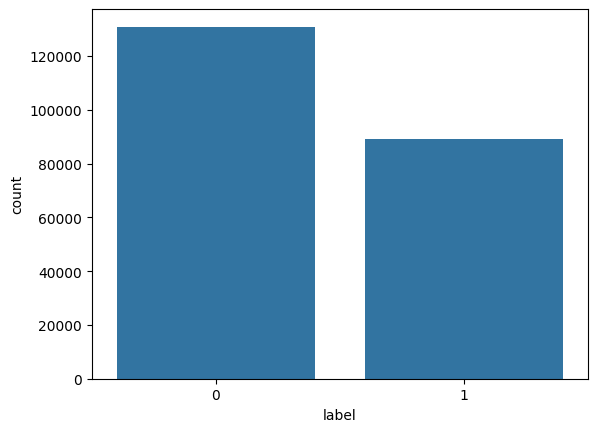

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x= labels['label'])

In [ ]:
labels['label'].value_counts()

,count
label,
0,130908
1,89117


In [ ]:
labels['label']=labels['label'].apply(lambda x: str(x))
print(len(labels))

220025


In [ ]:
train= "../input/histopathologic-cancer-detection/train"
#test= '../input/histopathologic-cancer-detection/test'
print(len(os.listdir(train)))

220025


In [ ]:
train_img= plt.imread('../input/histopathologic-cancer-detection/train/' + labels.iloc[0]['id'] + '.tif')

print('Image Shape:', train_img.shape)

Image Shape: (96, 96, 3)


0


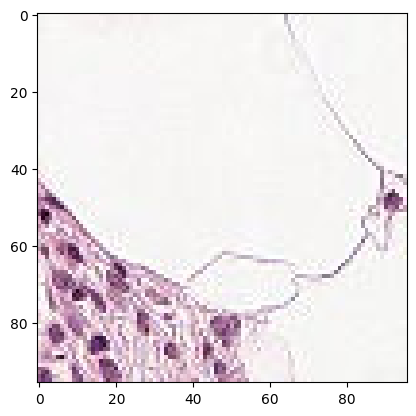

1


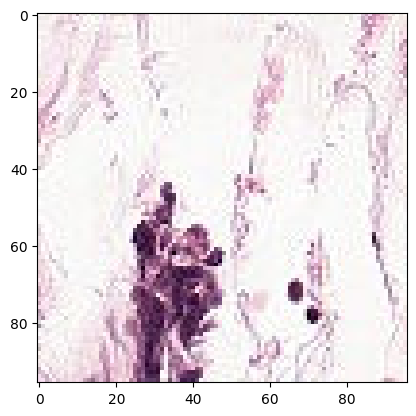

0


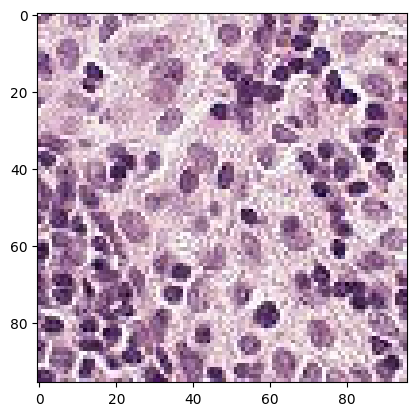

0


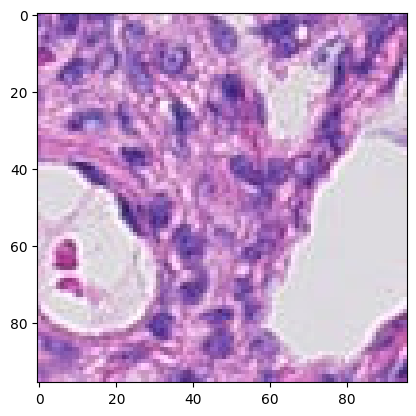

0


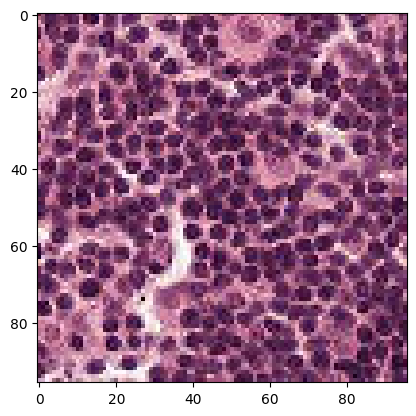

In [ ]:
for i in range(5) :
    train_img= plt.imread('../input/histopathologic-cancer-detection/train/' + labels.iloc[i]['id'] + '.tif')
    print(labels.iloc[i]['label'])
    plt.imshow(train_img)
    plt.show()

**DATA GENERATORS**

In [ ]:
y= labels['label']
from sklearn.model_selection import train_test_split

trainx, valx = train_test_split(labels,test_size=0.2, random_state= 99, stratify= y)
print(trainx.shape)
print(valx.shape)
print(trainx['label'].value_counts())
print(valx['label'].value_counts())

print(len(trainx['id']))
print(len(valx['id']))

(176020, 2)
(44005, 2)
label
0    104726
1     71294
Name: count, dtype: int64
label
0    26182
1    17823
Name: count, dtype: int64
176020
44005


In [ ]:
train='../input/histopathologic-cancer-detection/train'
valid= '../input/histopathologic-cancer-detection/train'
labels['id']=labels['id'].apply(lambda x: x+'.tif')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                                   horizontal_flip=True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x)

In [ ]:
datagen = ImageDataGenerator(
       horizontal_flip=True,
       vertical_flip=True,
       brightness_range=[0.5, 1.5],
       fill_mode='reflect',
       rotation_range=15,
       rescale=1./255,
       #shear_range=0.2,
       zoom_range=0.2,
       validation_split=0.2)
tragen= datagen.flow_from_dataframe(
    dataframe= labels,
    directory= train,
    x_col= 'id',
    y_col= 'label',
    batch_size= 64,
    shuffle= True,
    subset= 'training',
    seed= 2020,
    class_mode= 'binary',
    target_size= (96,96)
)

validgen=datagen.flow_from_dataframe(
    dataframe= labels,
    directory= valid,
    x_col= 'id',
    y_col= 'label',
    batch_size= 32,
    shuffle= False,
    subset= 'validation',
    seed= 2020,
    class_mode= 'binary',
    target_size= (96,96))

testgen=datagen.flow_from_dataframe(
    dataframe= labels,
    directory= train,
    x_col= 'id',
    y_col= 'label',
    batch_size= 32,
    shuffle= False,
    subset= 'validation',
    seed= 2020,
    class_mode= 'binary',
    target_size= (96,96))

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
tragen.class_indices['0']= 'No Tumor'
tragen.class_indices['1']= 'Tumor'
tragen.class_indices

{'0': 'No Tumor', '1': 'Tumor'}

In [ ]:
validgen.class_indices['0']= 'No Tumor'
validgen.class_indices['1']= 'Tumor'
validgen.class_indices

{'0': 'No Tumor', '1': 'Tumor'}

In [ ]:
testgen.class_indices['0']= 'No Tumor'
testgen.class_indices['1']= 'Tumor'
testgen.class_indices

{'0': 'No Tumor', '1': 'Tumor'}

In [ ]:
model= Sequential()
model.add(Conv2D(16,(3,3), activation= 'relu', input_shape=(96,96,3)))
model.add(BatchNormalization())
model.add(Conv2D(16,(3,3), activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(32,(3,3), activation= 'relu',use_bias= False))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3), activation= 'relu', use_bias= False))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3), activation= 'relu',use_bias= False))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation= 'relu', use_bias= False))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(96,(3,3), activation= 'relu', use_bias= False))
model.add(BatchNormalization())
model.add(Conv2D(96,(3,3), activation= 'relu', use_bias= False))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation= "sigmoid"))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 92, 92, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 92, 92, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 46, 46, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 32)          │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 44, 44, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 42, 42, 32)          │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 42, 42, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 19, 19, 64)          │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 19, 19, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 17, 17, 64)          │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 17, 17, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 310,609 (1.18 MB)

 Trainable params: 309,777 (1.18 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:
model.compile(optimizer= Adam(0.001),
              loss= 'binary_crossentropy',
              metrics= ["accuracy"])
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

STEP_SIZE_TRAIN=tragen.n//tragen.batch_size
STEP_SIZE_VALID=validgen.n//validgen.batch_size
STEP_SIZE_TEST=testgen.n//testgen.batch_size
earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1,
                             mode= 'max', restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1,
                            verbose=1,mode= 'max', factor=0.1, min_lr= 0.001)


history = model.fit(tragen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validgen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                    callbacks=[earlystop, reduce])




Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1020s 365ms/step - accuracy: 0.7645 - loss: 0.5071 - val_accuracy: 0.7750 - val_loss: 0.5203 - learning_rate: 0.0010
Epoch 2/20
   1/2750 ━━━━━━━━━━━━━━━━━━━━ 1:45 38ms/step - accuracy: 0.7656 - loss: 0.5024

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1s 352us/step - accuracy: 0.7656 - loss: 0.5024 - val_accuracy: 0.4000 - val_loss: 0.8853 - learning_rate: 0.0010
Epoch 3/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 955s 347ms/step - accuracy: 0.8260 - loss: 0.3917 - val_accuracy: 0.8010 - val_loss: 0.4926 - learning_rate: 0.0010
Epoch 4/20
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - accuracy: 0.7656 - loss: 0.4381 - val_accuracy: 0.6000 - val_loss: 0.5744 - learning_rate: 0.0010
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
model.metrics_names

['loss', 'compile_metrics']

In [ ]:
tragen.class_indices

{'0': 'No Tumor', '1': 'Tumor'}

In [ ]:
val_loss, val_acc = model.evaluate(testgen, steps=STEP_SIZE_TEST)

print('val_loss:', val_loss)
print('val_acc:', val_acc)


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 171s 124ms/step - accuracy: 0.7786 - loss: 0.5088
val_loss: 0.505297839641571
val_acc: 0.7800909280776978


<Figure size 640x480 with 0 Axes>

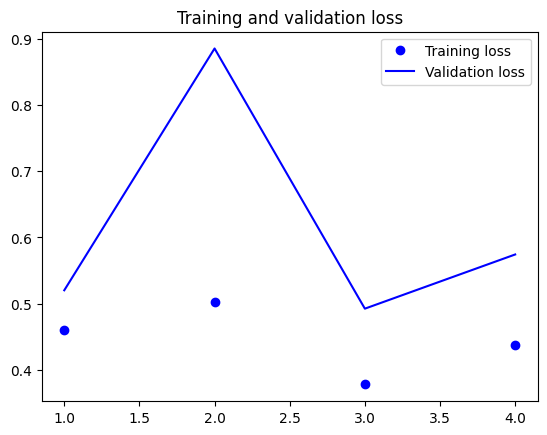

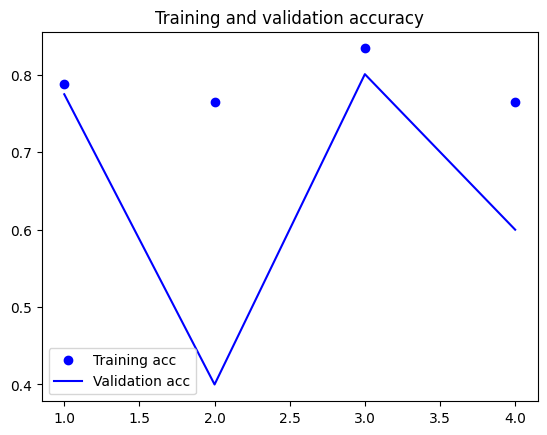

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [ ]:
import time
t= time.time()
export= './{}.h5'.format(int(t))
print(export)

model.save(export)

./1724927430.h5


In [ ]:
t= time.time()
export_tf= "./{}".format(int(t))
print(export_tf)
tf.saved_model.save(model, export_tf)

./1724927430
